In [5]:
from IPython.core.debugger import set_trace

In [6]:
import numpy as np
import os

In [7]:
#display all values from array
np.set_printoptions(threshold=np.nan)

#display not in scientific format
np.set_printoptions(suppress=True)

In [37]:
DATA_PATH = 'data'

DATA_FREQUENCY = 500
SAMPLING_RATE = 5
FREQUENCY_TO_SAMPLING_RATIO = DATA_FREQUENCY // SAMPLING_RATE

In [9]:
def parse_file(file):
    lines = file.split('\n')
    headers = lines[0].split('\t')
    # to one before last because the last one is empty
    data = lines[1:-1]

    number_of_lines = len(data)

    float_data = np.zeros((number_of_lines, len(headers)))
    for line_number, line in enumerate(data):
        values = [float(value) for value in line.split('\t')]
        float_data[line_number, :] = values

    return float_data[::SAMPLING_RATE], headers


def read_input_files(end, data_path):
    input_path = os.path.join(data_path, 'input_500Hz/sick')
    input_file_names = os.listdir(input_path)
    input_file_names.sort(key=int)

    start = None

    files_content = []
    for file_name in input_file_names[start:end]:
        file_path = os.path.join(input_path, file_name)
        file = open(file_path, 'r')
        (columns, headers) = parse_file(file.read())
        print('Loaded input file:', file_name)
        file.close()
        files_content.append(columns)
    print('--Input files loaded--')
    return files_content, headers


def create_target_index(value):
    value = int(value)
    return int(value * FREQUENCY_TO_SAMPLING_RATIO)


def read_target_files(end, data_path):
    targets_path = os.path.join(data_path, 'targets')
    targets_file_name = os.listdir(targets_path)[0]
    targets_file_path = os.path.join(targets_path, targets_file_name)

    file = open(targets_file_path, 'r')
    targets_content = file.read()
    file.close()

    # last line is empty
    lines = targets_content.split('\n')[:-1]
    targets = []
    for number, line in enumerate(lines, 1):
        targets.append([(int(value), create_target_index(value)) for value in line.split(',')])
    print('--Target files loaded--')
    return targets[:end]


def read_data(end):
    (input_data, headers) = read_input_files(end, DATA_PATH)
    targets_data = read_target_files(end, DATA_PATH)

    return input_data, targets_data, headers


In [17]:
import random


def create_chunks_with_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
    #     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)

    for seizure_number in range(0, number_of_chunks):
        (seizure_time, seizure_index) = seizure_seconds[seizure_number]
        chunk_start_index = seizure_index
        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[seizure_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # seizure
        chunks_target[seizure_number] = 1

    return (chunks_input, chunks_target)


def is_in_seizure_range(index, seizure_seconds, chunk_size):
    for (seizure_time, seizure_index) in seizure_seconds:
        seizure_start_index = seizure_index
        seizure_end_index = seizure_start_index + chunk_size
        if index in range(seizure_start_index, seizure_end_index):
            return True

    return False


def create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds):
    start_index = random.randint(0, data_size - chunk_size)

    while (is_in_seizure_range(start_index, seizure_seconds, chunk_size)):
        start_index = random.randint(0, data_size - chunk_size)

    return start_index


def create_chunks_without_seizures(patient_data, seizure_seconds, chunk_size):
    number_of_chunks = len(seizure_seconds)
    #     16 when without time
    chunks_input = np.zeros((number_of_chunks, chunk_size, 17))
    chunks_target = np.zeros(number_of_chunks)
    (data_size, channels) = patient_data.shape

    for chunk_number in range(0, number_of_chunks):
        chunk_start_index = create_non_seizure_data_start_index(data_size, chunk_size, seizure_seconds)

        chunk_end_index = chunk_start_index + chunk_size
        chunks_input[chunk_number] = patient_data[chunk_start_index:chunk_end_index, :]
        # non-seizure
        chunks_target[chunk_number] = 0

    return (chunks_input, chunks_target)


def flatten_chunks(chunks_input, chunks_target):
    train_input = []
    train_target = []

    for patient_number in range(0, len(chunks_input)):
        patient_data = chunks_input[patient_number]
        patient_targets = chunks_target[patient_number]
        for chunk_number in range(0, len(patient_data)):
            train_input.append(patient_data[chunk_number])
            train_target.append(patient_targets[chunk_number])

    train_input = np.array(train_input)
    train_target = np.array(train_target)

    #remove time column
    train_input = train_input[:, :, :-1]
    
    return train_input, train_target 


def prepare_chunks(input, target, chunk_size):
    chunks_input = []
    chunks_target = []

    for patient_number in range(0, len(input)):
        patient_chunks_input = []
        patient_chunks_target = []
        seizure_seconds = target[patient_number]
        patient_data = input[patient_number]
        (seizure_chunks_input, seizure_chunks_target) = create_chunks_with_seizures(patient_data,
                                                                                    seizure_seconds,
                                                                                    chunk_size)
        patient_chunks_input.extend(seizure_chunks_input)
        patient_chunks_target.extend(seizure_chunks_target)

        (non_seizure_chunks_input, non_seizure_chunks_target) = create_chunks_without_seizures(patient_data,
                                                                                               seizure_seconds,
                                                                                               chunk_size)
        patient_chunks_input.extend(non_seizure_chunks_input)
        patient_chunks_target.extend(non_seizure_chunks_target)

        chunks_input.append(np.array(patient_chunks_input))
        chunks_target.append(np.array(patient_chunks_target))

    return np.array(chunks_input), np.array(chunks_target)

In [40]:
# (input, target, headers) = read_data(end=104)
(chunks_input, chunks_target) = prepare_chunks(input, target, chunk_size=4*100)
(train_input, train_target) = flatten_chunks(chunks_input, chunks_target)

In [49]:
test_set_size = 7

test_input = train_input[-test_set_size:]
test_target = train_target[-test_set_size:]

train_input = train_input[:-test_set_size]
train_target = train_target[:-test_set_size]

In [52]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(400, 16)))
model.add(layers.Dense(1000, activation='relu'))
model.add(layers.Dense(30, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
#     optimizer='adam',
              optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_input,
                    train_target,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.05,
                   shuffle=True)

score = model.evaluate(test_input, test_target, batch_size=64)

Train on 1110 samples, validate on 59 samples
Epoch 1/100
1110/1110 [==============================] - 0s 318us/step - loss: 5.9872 - acc: 0.5162 - val_loss: 6.8575 - val_acc: 0.5085
Epoch 2/100
1110/1110 [==============================] - 0s 159us/step - loss: 4.1387 - acc: 0.6721 - val_loss: 6.4590 - val_acc: 0.5254
Epoch 3/100
1110/1110 [==============================] - 0s 159us/step - loss: 3.2239 - acc: 0.7198 - val_loss: 6.0131 - val_acc: 0.5085
Epoch 4/100
1110/1110 [==============================] - 0s 168us/step - loss: 2.2015 - acc: 0.7982 - val_loss: 3.9338 - val_acc: 0.5593
Epoch 5/100
1110/1110 [==============================] - 0s 170us/step - loss: 1.5916 - acc: 0.8495 - val_loss: 4.3946 - val_acc: 0.5424
Epoch 6/100
1110/1110 [==============================] - 0s 160us/step - loss: 1.2383 - acc: 0.8559 - val_loss: 3.2430 - val_acc: 0.5593
Epoch 7/100
1110/1110 [==============================] - 0s 161us/step - loss: 0.8773 - acc: 0.8964 - val_loss: 3.5458 - val_acc: 0.

1110/1110 [==============================] - 0s 156us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.1439 - val_acc: 0.5593
Epoch 61/100
1110/1110 [==============================] - 0s 148us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.1835 - val_acc: 0.5593
Epoch 62/100
1110/1110 [==============================] - 0s 150us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.2051 - val_acc: 0.5593
Epoch 63/100
1110/1110 [==============================] - 0s 149us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.2542 - val_acc: 0.5424
Epoch 64/100
1110/1110 [==============================] - 0s 151us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.2671 - val_acc: 0.5424
Epoch 65/100
1110/1110 [==============================] - 0s 143us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.2899 - val_acc: 0.5424
Epoch 66/100
1110/1110 [==============================] - 0s 153us/step - loss: 0.1443 - acc: 0.9910 - val_loss: 6.3013 - val_acc: 0.5424
Epoch 67/100
1110/1110 [=======================

In [54]:
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 71.43%


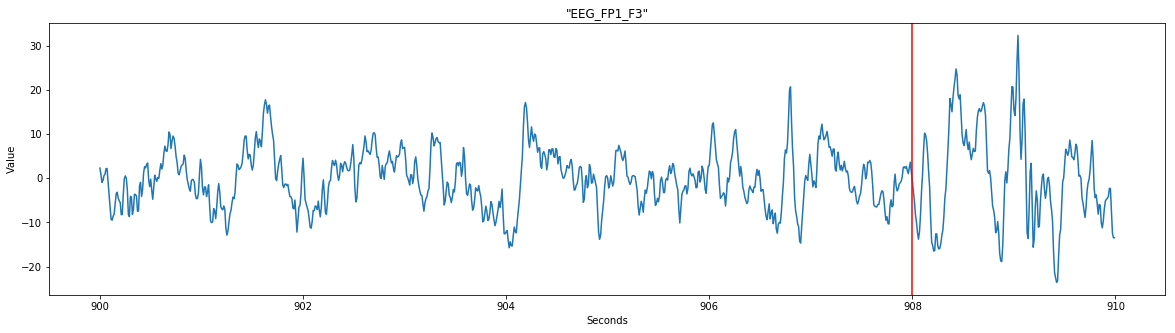

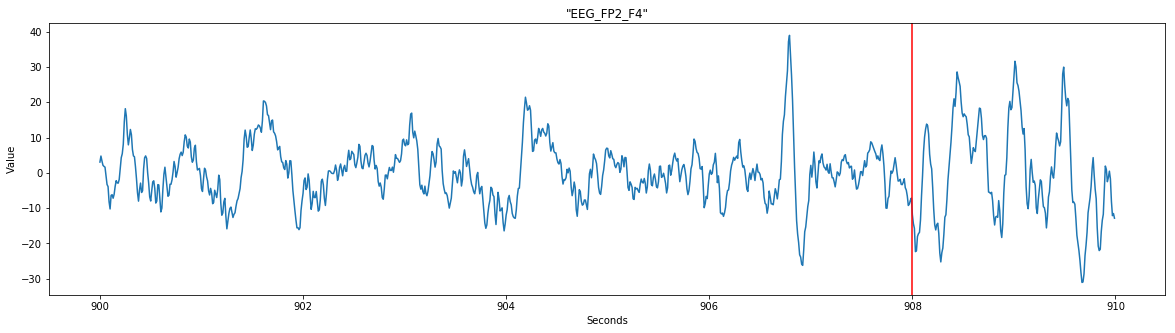

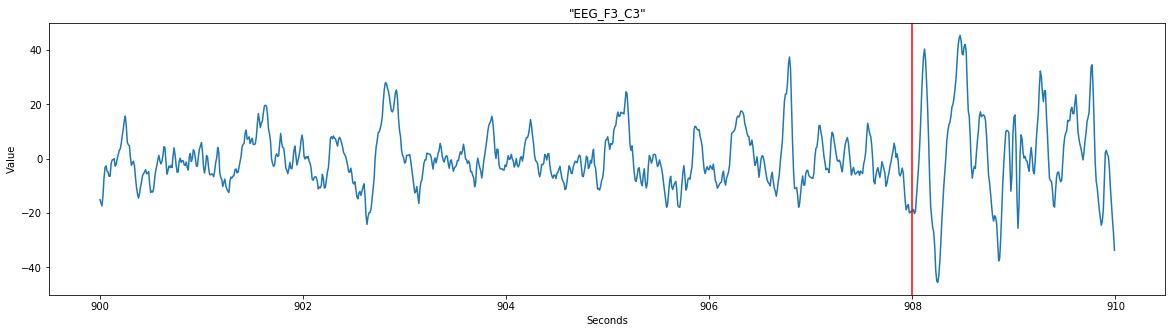

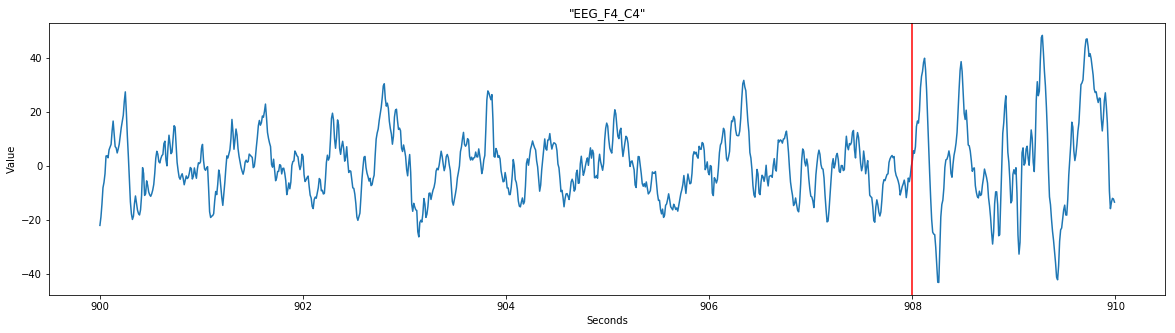

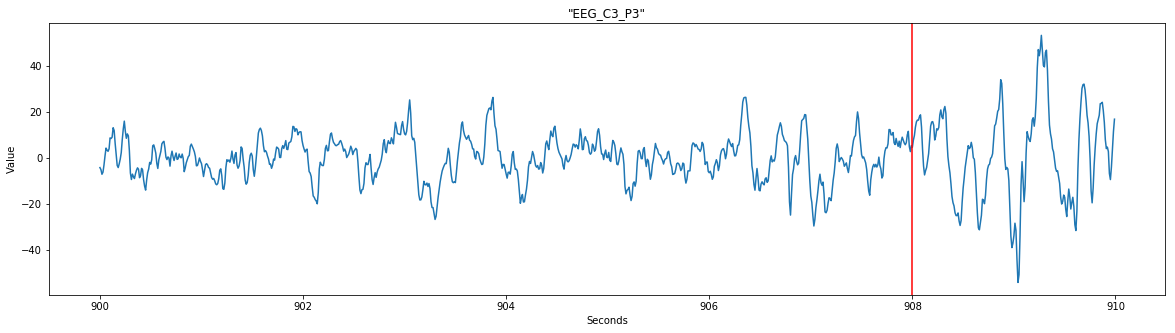

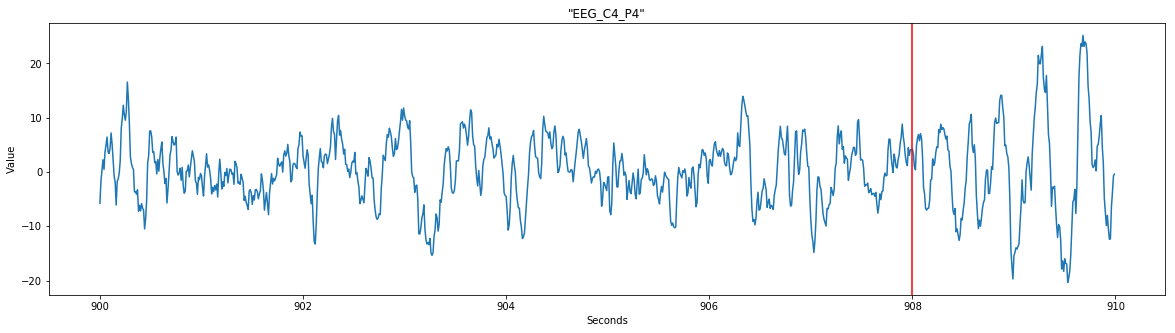

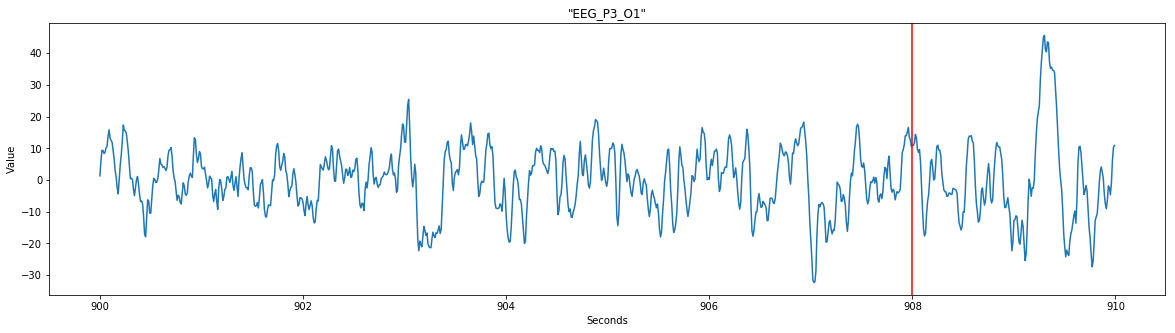

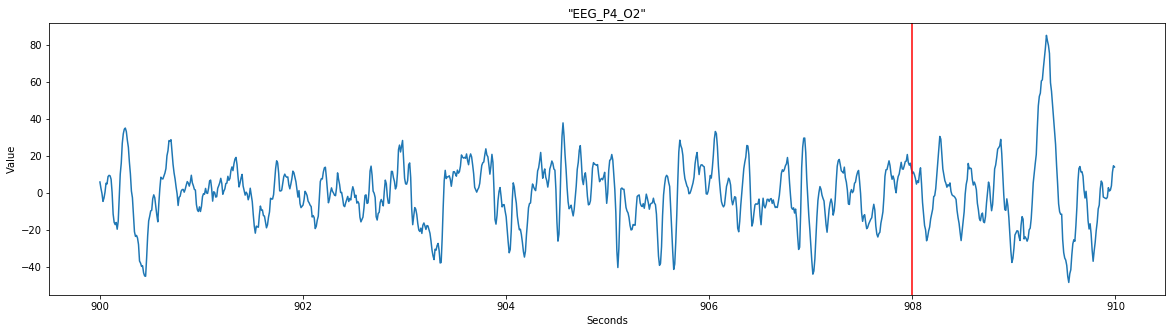

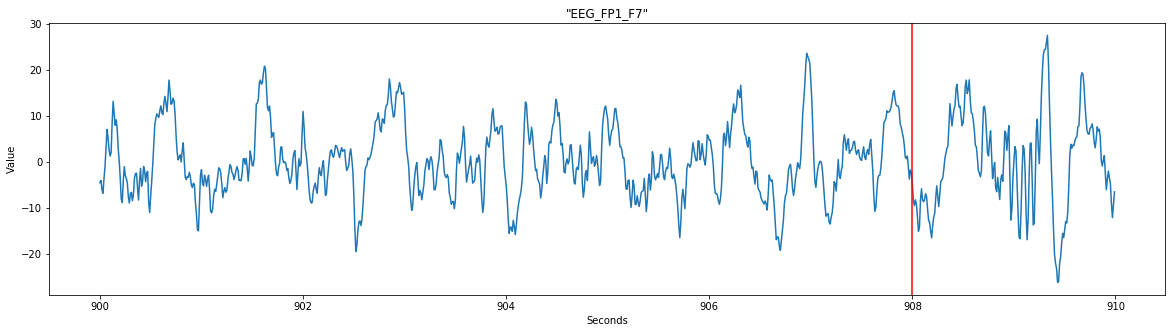

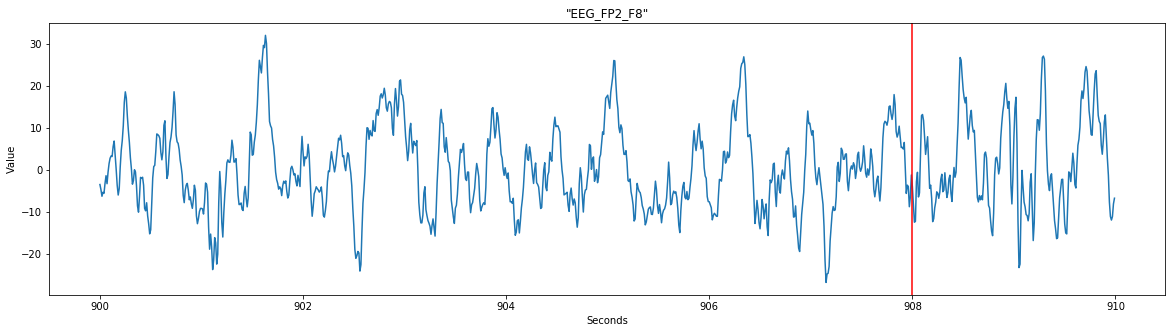

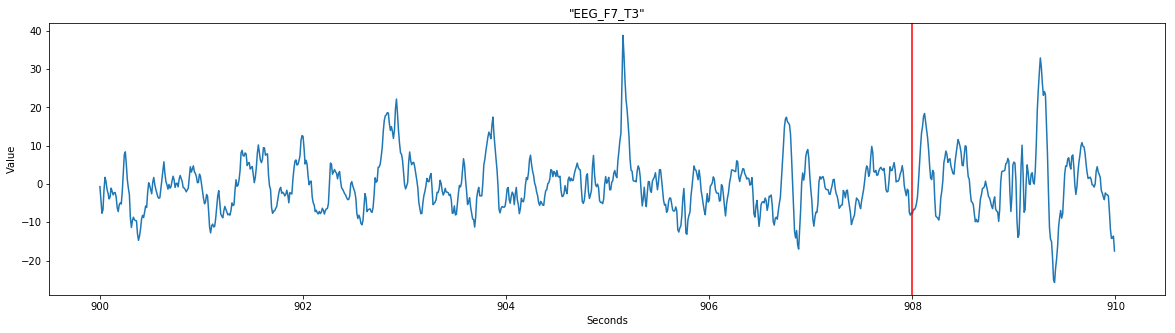

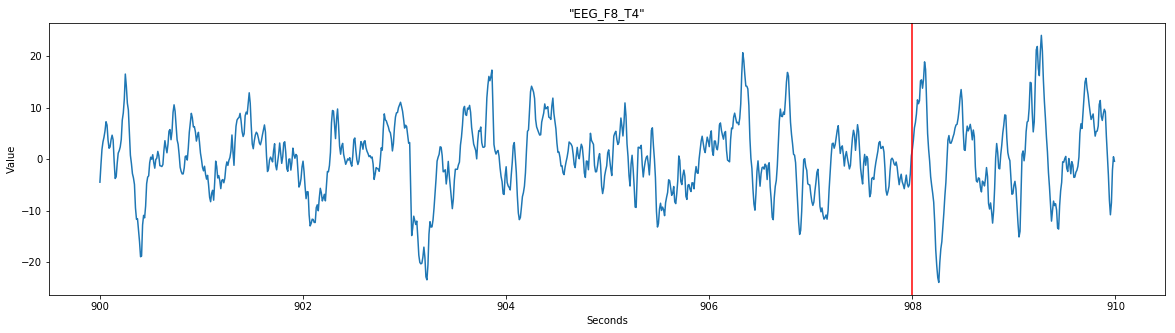

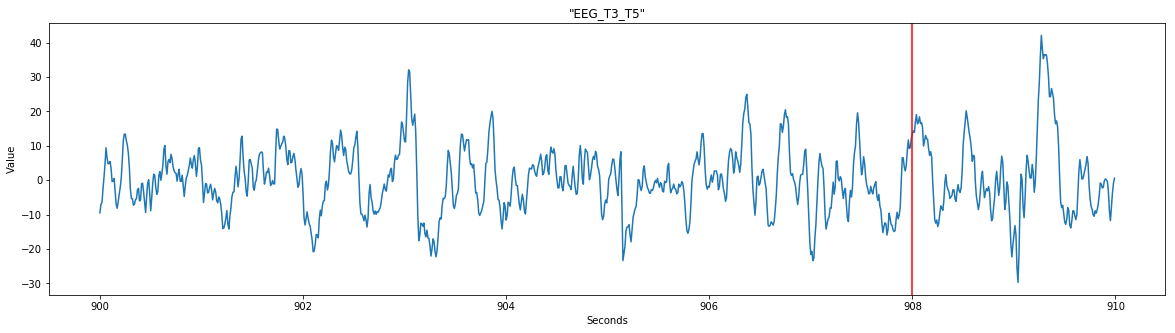

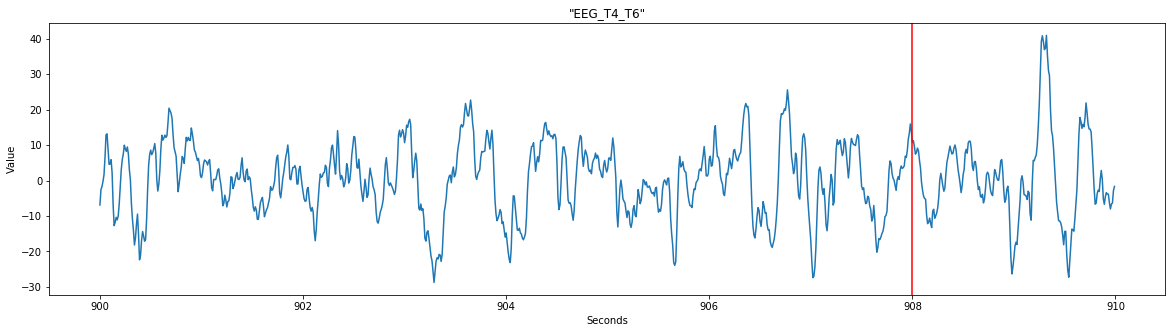

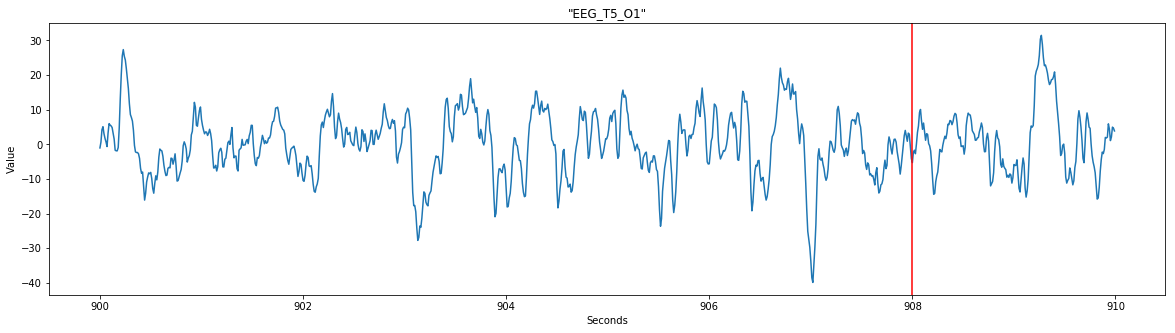

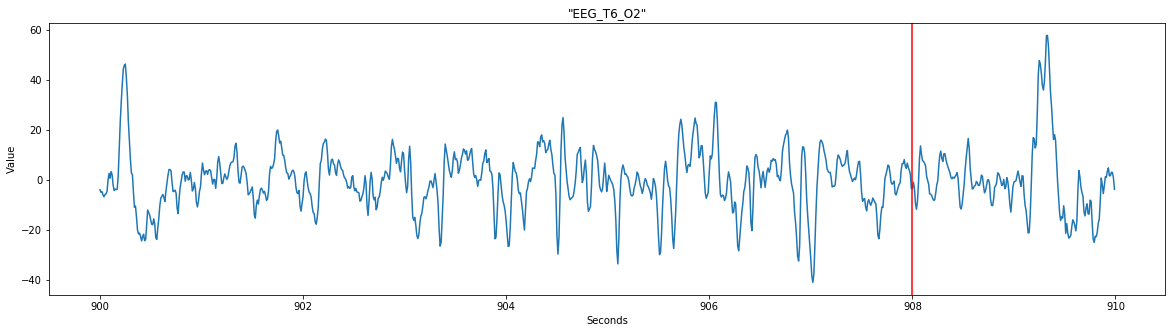

In [38]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]


def draw_plots(input, target, headers, patient, end_second, start_second=0):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        start = start_second * FREQUENCY_TO_SAMPLING_RATIO
        end = end_second * FREQUENCY_TO_SAMPLING_RATIO
        plt.plot(time_column[start:end], channel[start:end])
        draw_targets_in_range(targets, start_second, end_second)
     
    
def draw_targets_in_range(targets, start_second, end_second):
    for (target, target_index) in targets:
        if (target >= start_second) and (target <= end_second):
            plt.axvline(x=target, color='r')
            
            
draw_plots(input, target, headers, patient=0, start_second=900, end_second=910)

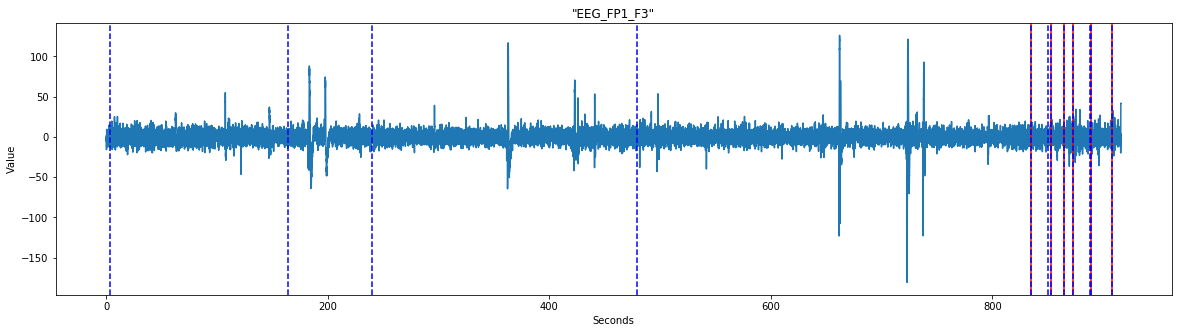

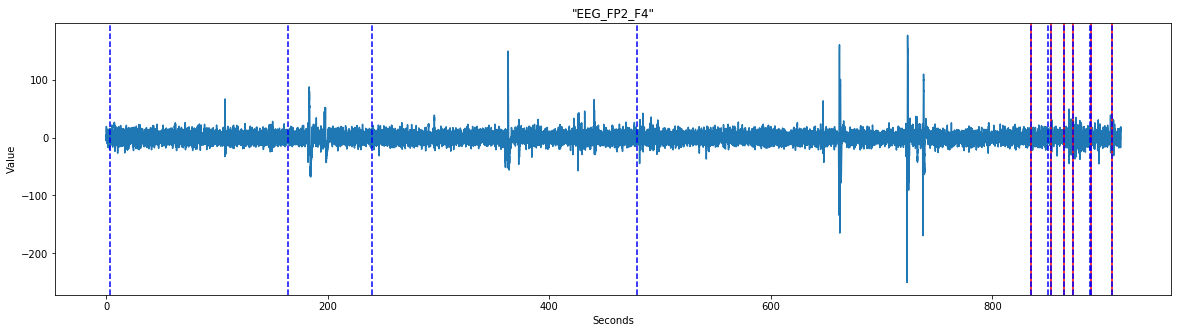

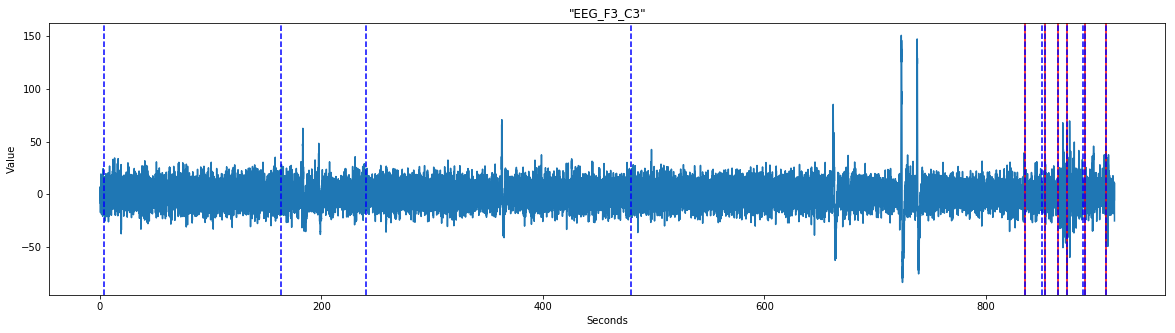

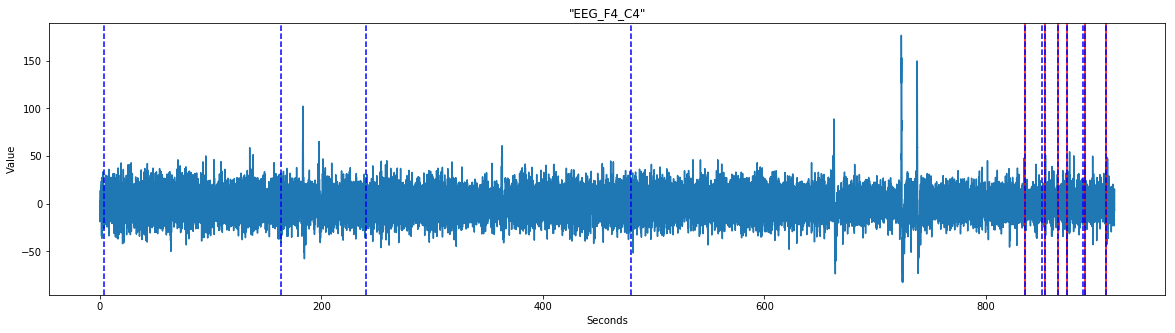

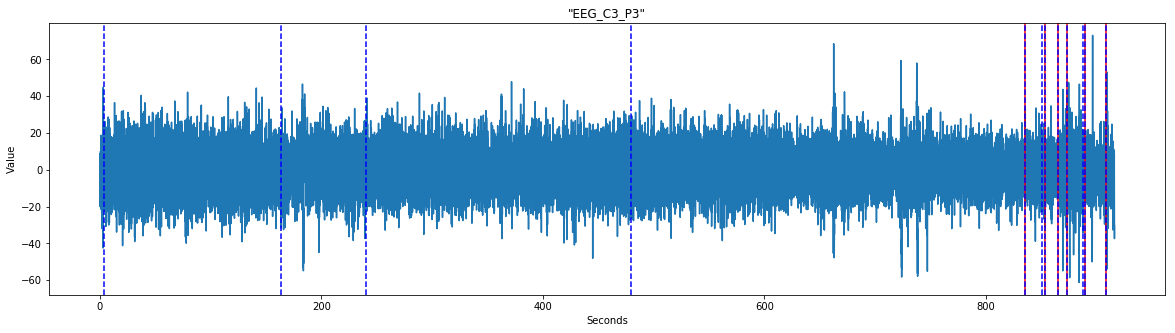

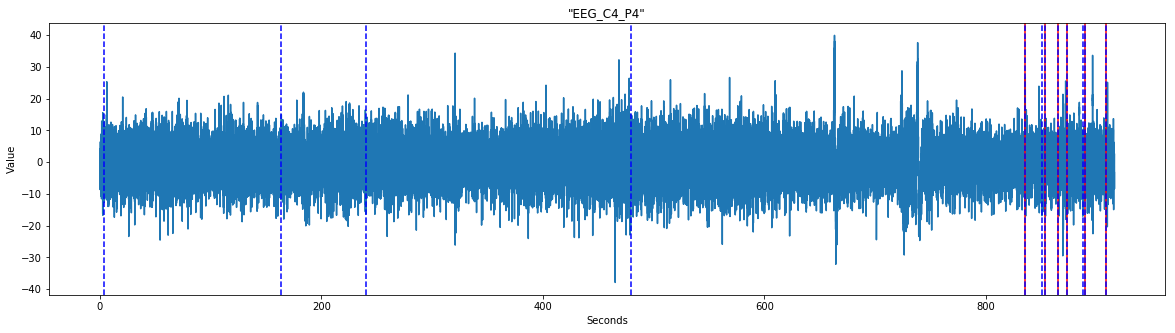

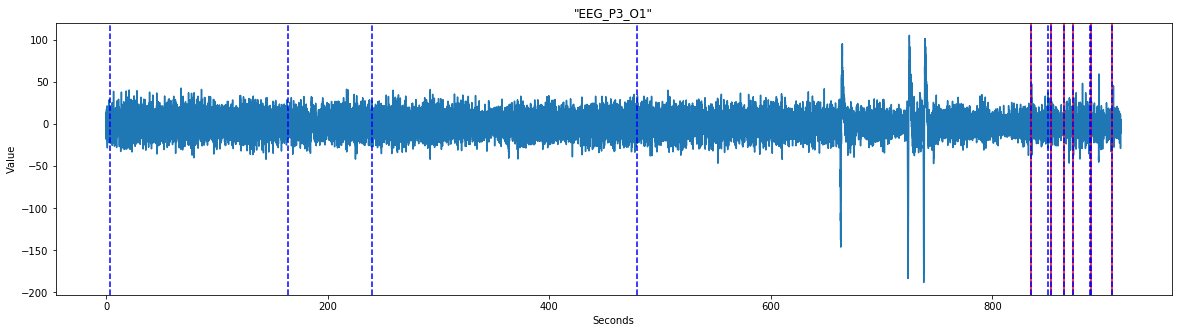

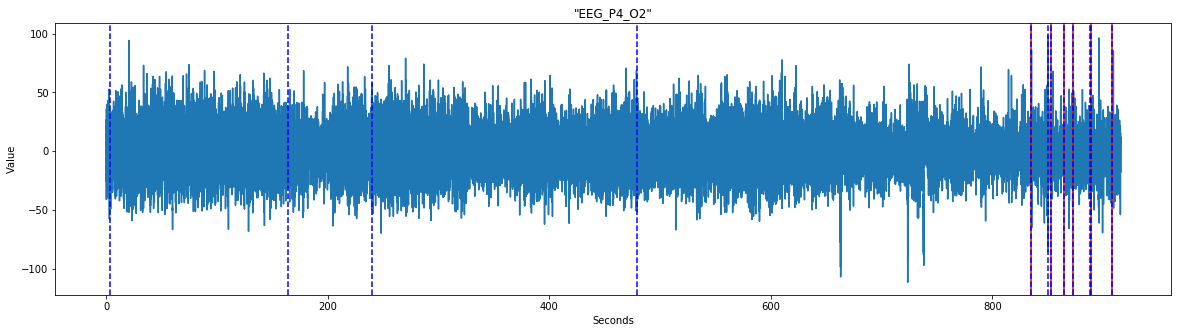

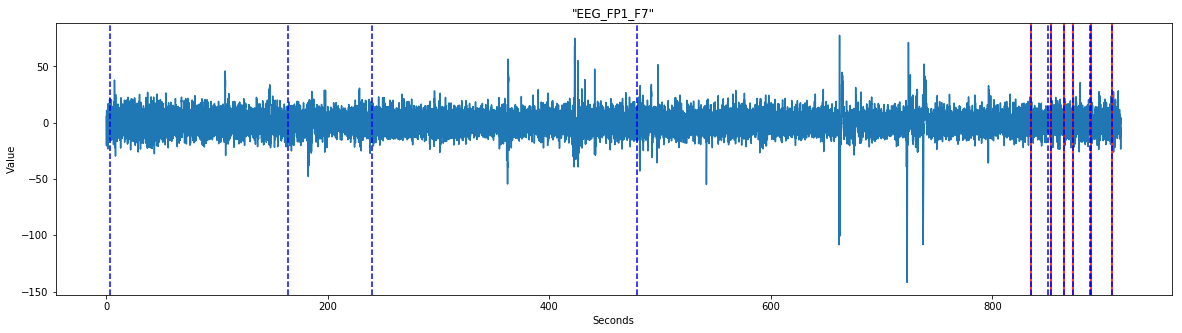

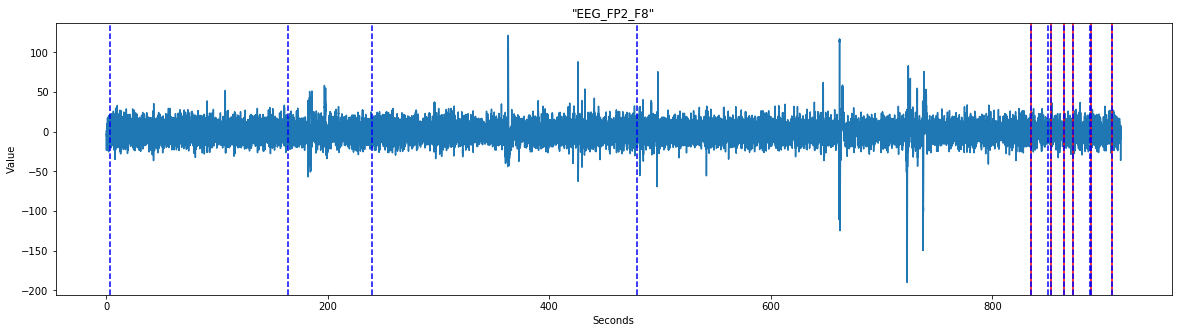

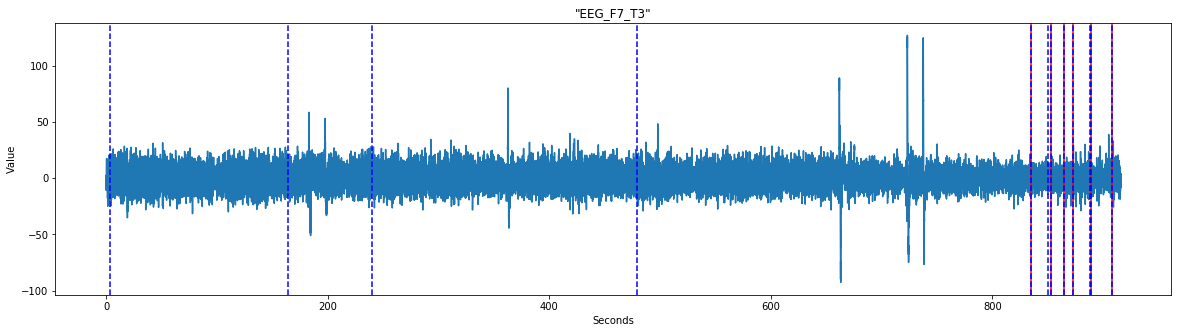

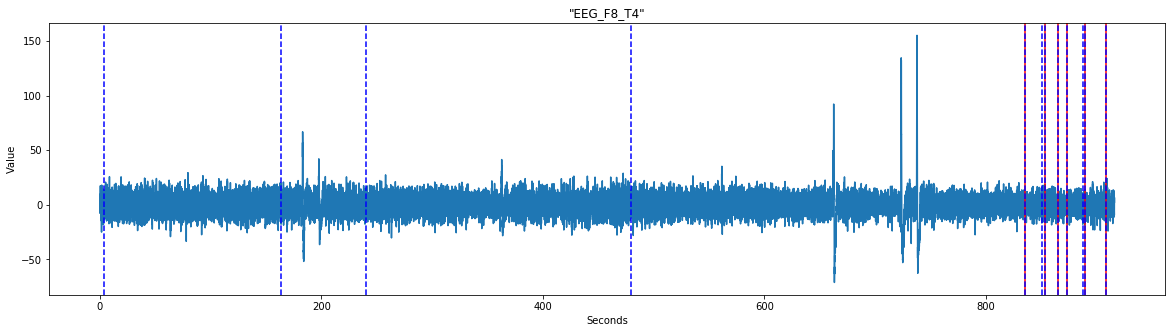

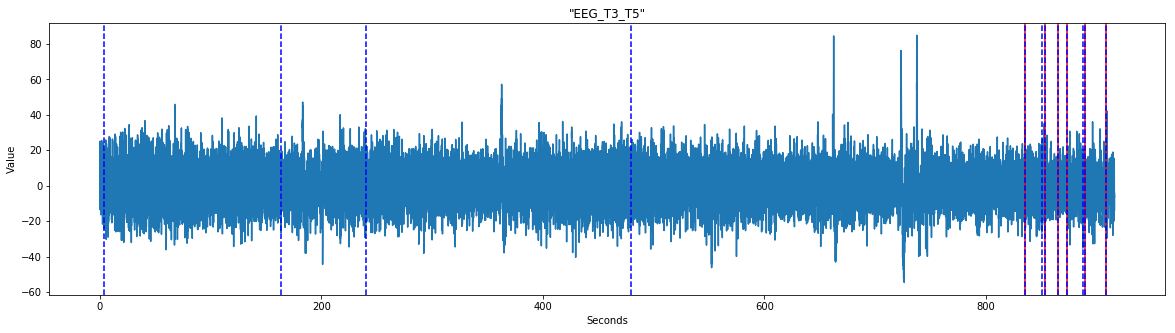

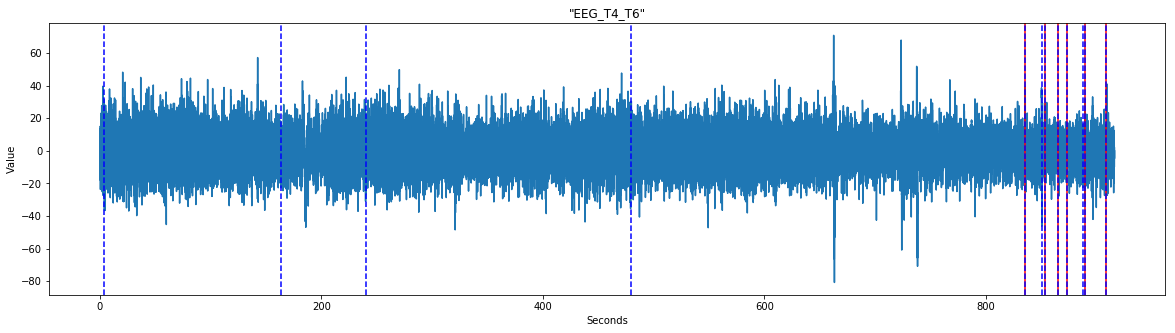

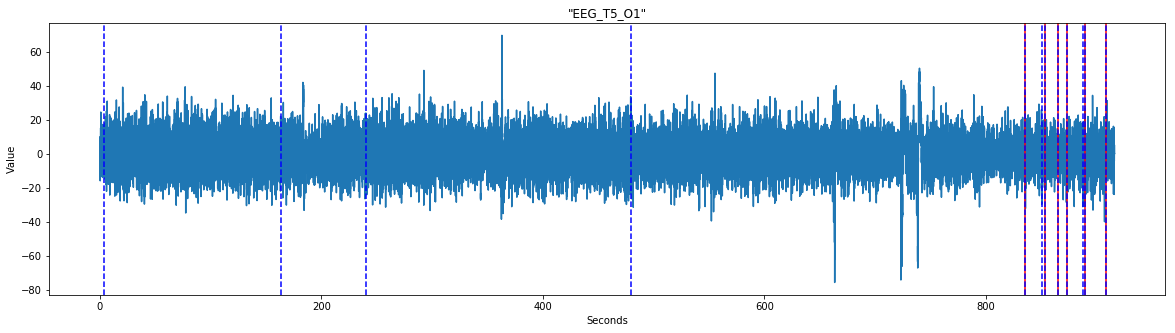

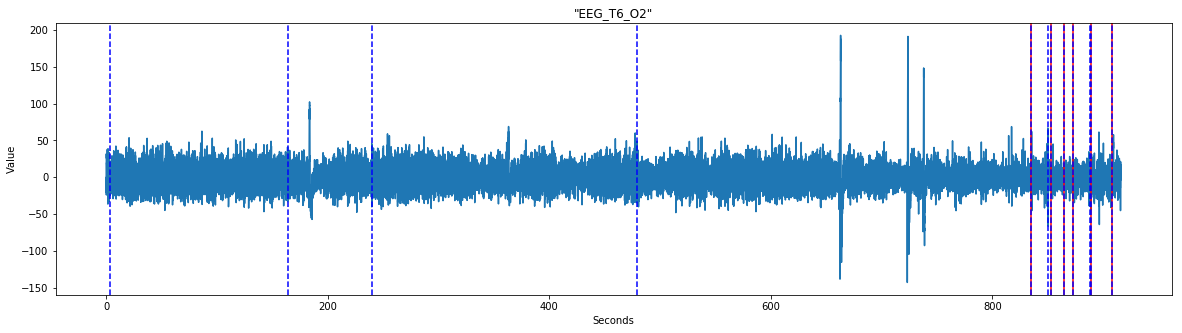

In [39]:
#draw chosen chunks
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [20, 5]


def draw_plots_with_chunks(input, target, headers, patient, chunks_input, to_pdf=False):
    patient_columns = input[patient]
    targets = target[patient]
    time_column = patient_columns[:, -1]
    channel_columns = patient_columns[:, :-1]
    (rows, columns) = channel_columns.shape
    chunks_input = chunks_input[patient]
    
    for column in range(columns):
        channel = channel_columns[:, column]
        plt.figure(column)
        plt.xlabel('Seconds')
        plt.ylabel('Value')
        plt.title(headers[column])
        plt.plot(time_column, channel)
        draw_targets(targets)
        draw_chunks_start(chunks_input)
        if to_pdf:
            plt.savefig("chanel-{}.pdf".format(column), bbox_inches='tight')
      
    
def draw_targets(targets):
    for (target, target_index) in targets:
        plt.axvline(x=target, color='r')

        
def draw_chunks_start(chunks_input):
    for chunk_number in range(0, len(chunks_input)):
        chunk = chunks_input[chunk_number]
        
        plt.axvline(x=chunk[0, -1], color='b', linestyle="--")
        
        
draw_plots_with_chunks(input, target, headers, patient=0, chunks_input = chunks_input, to_pdf=False)